# **Malaria Detection Using Convolutional Neural Networks (CNN)**
---

## **Overview**
This code demonstrates how to build and train a Convolutional Neural Network (CNN) to detect malaria-infected cells in microscopy images. The dataset used contains images of two classes: parasitized (malaria-infected) cells and uninfected cells. The approach includes loading and preprocessing the data, building a CNN model with multiple layers, training the model, and evaluating its performance. The model's performance is evaluated using metrics such as accuracy, precision, recall, AUC, ROC curve, and confusion matrix. Data augmentation techniques are applied to improve model generalization, and callbacks like early stopping and learning rate reduction are used to optimize the training process.

## **Installing Required Libraries**
- Installs the necessary libraries `tensorflow` and `Keras` for deep learning, and downloads the dataset containing malaria-infected and uninfected cell images.

In [1]:
!pip install tensorflow Keras

In [2]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
100% 672M/675M [00:31<00:00, 22.5MB/s]
100% 675M/675M [00:31<00:00, 22.2MB/s]


## **Importing Required Libraries**
- `os`: Used for interacting with the operating system, including file handling (e.g., checking file existence, listing files in a directory).
- `zipfile`: Provides tools for working with zip files. Here, it is used to extract the dataset after downloading it.
- `cv2`: OpenCV library used to handle images, such as reading and resizing images.
- `numpy`: A powerful numerical computing library, mainly used for working with arrays. It’s used to handle image data as NumPy arrays.
- `PIL`: The Python Imaging Library (Pillow) used for basic image processing tasks like resizing and converting between image formats.
- `itertools`: Used for generating iterators, here specifically to iterate over indices for confusion matrix visualization.
- `matplotlib.pyplot`: A popular plotting library used to generate graphs, including accuracy, loss, ROC curves, etc.
- `train_test_split`: A function from sklearn.model_selection used to split the dataset into training and testing sets.
- `keras`: The Keras deep learning API used to build and train the CNN model.
- `layers`: Contains various layers (e.g., convolutional, pooling, dense) used to build the CNN architecture.
- `regularizers`: (Not used in the code but can be imported to apply regularization to layers for preventing overfitting).
- `EarlyStopping` and `ReduceLROnPlateau`: Callbacks from Keras used to stop training early if the model's performance stops improving, and reduce the learning rate when the model's validation performance plateaus.
- `ImageDataGenerator`: Used for real-time data augmentation during model training to artificially expand the dataset.
- `roc_curve`, `auc`, `precision_recall_curve`, `confusion_matrix`, - `classification_report`: Evaluation metrics from sklearn used to analyze the model's performance.

In [26]:
import os
import zipfile
import cv2
import numpy as np
from PIL import Image
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

In [5]:
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(1000)

## **Extracting the Dataset**
- After downloading the dataset, the zip file is extracted to a directory (malaria_dataset) using Python's zipfile module. This step unpacks the images for further processing.

In [6]:
with zipfile.ZipFile("cell-images-for-detecting-malaria.zip", 'r') as zip_ref:
    zip_ref.extractall("malaria_dataset")

## **Loading and Preprocessing Data**
- `img_path` stores the directory path where the images were extracted.
- `SIZE = 64`: Images will be resized to 64x64 pixels.
- `dataset` will hold the image data, and `labels` will hold the corresponding class labels (0 for parasitized, 1 for uninfected).

In [7]:
img_path = "/content/malaria_dataset"
SIZE = 64

dataset = []
labels = []

## **Loading Parasitized Images:**
- The code lists all images in the "Parasitized" directory, reads each image using OpenCV (`cv2.imread()`), converts it to RGB format, resizes it to 64x64, and adds it to the `dataset` list. The corresponding label `0` (parasitized) is added to the `labels` list.

In [8]:
parasitized_images = os.listdir(img_path + "/cell_images/Parasitized/")

for i, img_name in enumerate(parasitized_images):
    if img_name.split(".")[1] == "png":
        img = cv2.imread(img_path + "/cell_images/Parasitized/" + img_name)
        img = Image.fromarray(img, "RGB")
        img = img.resize((SIZE, SIZE))
        dataset.append(np.array(img))
        labels.append(0)

## **Loading Uninfected Images:**
- Similarly, the code loads images from the "Uninfected" directory, resizes them, and adds them to `dataset`. Each uninfected image is labeled as `1`.

In [9]:
uninfected_images = os.listdir(img_path + "/cell_images/Uninfected/")

for i, img_name in enumerate(uninfected_images):
    if img_name.split(".")[1] == "png":
        img = cv2.imread(img_path + "/cell_images/Uninfected/" + img_name)
        img = Image.fromarray(img, "RGB")
        img = img.resize((SIZE, SIZE))
        dataset.append(np.array(img))
        labels.append(1)

## **Data Normalization and Splitting**
- The images are normalized by dividing each pixel value by 255, converting it to a [0, 1] scale.
- The dataset is then split into training (80%) and testing (20%) sets using `train_test_split()`.

In [10]:
dataset = np.array(dataset) / 255.0
labels = np.array(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset, labels, test_size=0.2, random_state=42
)

## **Data Augmentation**
- `ImageDataGenerator` is used to apply real-time data augmentation, which helps improve model generalization by generating variations of the input images.

- **Key parameters**:
  - `rotation_range=20`: Rotates images randomly by up to 20 degrees.
  - `width_shift_range=0.2`, `height_shift_range=0.2`: Random horizontal and vertical shifts by up to 20% of the image size.
  - `shear_range=0.2`: Applies a shear transformation.
  - `zoom_range=0.2`: Random zoom effect.
  - `horizontal_flip=True`: Randomly flips images horizontally.
  - `fill_mode='nearest'`: Fills newly created pixels with the nearest value.

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## **Building the CNN Model**
- The model is a sequential CNN with several layers:
  - `Conv2D`: Convolutional layer with 32 filters, 3x3 kernel, ReLU activation, and same padding (output size = input size).
  - `MaxPooling2D`: Reduces the spatial dimensions of the feature maps by taking the maximum value from a 2x2 window.
  - `BatchNormalization`: Normalizes the outputs of the convolutional layers to improve training stability.
  - `Dropout`: Randomly sets 20% of the neurons to zero during training to prevent overfitting.
  - `Flatten`: Converts the 2D feature map into a 1D array for fully connected layers.
  - `Dense`: Fully connected layers. The final layer has a single neuron with a sigmoid activation function to output a probability (0 or 1).

In [13]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(SIZE, SIZE, 3)),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## **Compiling the Model**
- The model is compiled using the Adam optimizer with a small learning rate (0.0001), which is commonly used in deep learning.
- Binary cross-entropy is used as the loss function, suitable for binary classification tasks (parasitized vs uninfected).
- Metrics include accuracy, precision, recall, and AUC (Area Under the Curve), which are evaluated during training.

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,339,873 (16.56 MB)

 Trainable params: 4,338,209 (16.55 MB)

 Non-trainable params: 1,664 (6.50 KB)

## **Training the Model**
- The model is trained with real-time data augmentation using datagen.flow().
- `EarlyStopping` stops training if the validation loss does not improve for 5 consecutive epochs.
- `ReduceLROnPlateau` reduces the learning rate by half if the validation loss plateaus for 3 epochs.
- Batch size is set to `64`, and the model will train for a maximum of `30` `epochs`.

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [17]:
batch_size = 64

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - AUC: 0.6378 - Precision: 0.6027 - Recall: 0.6156 - accuracy: 0.6037 - loss: 0.7808 - val_AUC: 0.7226 - val_Precision: 0.5007 - val_Recall: 0.9901 - val_accuracy: 0.5089 - val_loss: 0.9932 - learning_rate: 1.0000e-04
Epoch 2/30
  1/344 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - AUC: 0.7222 - Precision: 0.6389 - Recall: 0.7188 - accuracy: 0.6562 - loss: 0.6527

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7222 - Precision: 0.6389 - Recall: 0.7188 - accuracy: 0.6562 - loss: 0.6527 - val_AUC: 0.7231 - val_Precision: 0.5008 - val_Recall: 0.9890 - val_accuracy: 0.5091 - val_loss: 0.9908 - learning_rate: 1.0000e-04
Epoch 3/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 64s 107ms/step - AUC: 0.7447 - Precision: 0.6760 - Recall: 0.7051 - accuracy: 0.6859 - loss: 0.6205 - val_AUC: 0.8897 - val_Precision: 0.5813 - val_Recall: 0.9602 - val_accuracy: 0.6397 - val_loss: 0.8308 - learning_rate: 1.0000e-04
Epoch 4/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7798 - Precision: 0.8065 - Recall: 0.6944 - accuracy: 0.7344 - loss: 0.5987 - val_AUC: 0.8934 - val_Precision: 0.5878 - val_Recall: 0.9595 - val_accuracy: 0.6486 - val_loss: 0.7884 - learning_rate: 1.0000e-04
Epoch 5/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 41s 108ms/step - AUC: 0.8539 - Precision: 0.7704 - Recall: 0.8008 - accuracy: 0.7802 - loss: 0.4803 - val_AUC: 0.9101 - val_Precision: 0.6742 - val_Recall: 0.

## **Evaluating the Model**
- The model's performance is evaluated on the test set using the specified metrics.

In [18]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation AUC: {val_auc:.2f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9756 - Precision: 0.8936 - Recall: 0.9670 - accuracy: 0.9262 - loss: 0.2129
Validation Accuracy: 0.93
Validation Loss: 0.22
Validation Precision: 0.89
Validation Recall: 0.97
Validation AUC: 0.97


## **Visualization of Results**
- Various plots are created:
  - Accuracy and Loss: Tracks the training and validation accuracy and loss over epochs.
  - ROC Curve: Shows the trade-off between sensitivity and specificity at various thresholds.
  - Precision-Recall Curve: Visualizes the relationship between precision and recall.
  - Confusion Matrix: Displays the true vs predicted labels to show the number of correct and incorrect classifications.

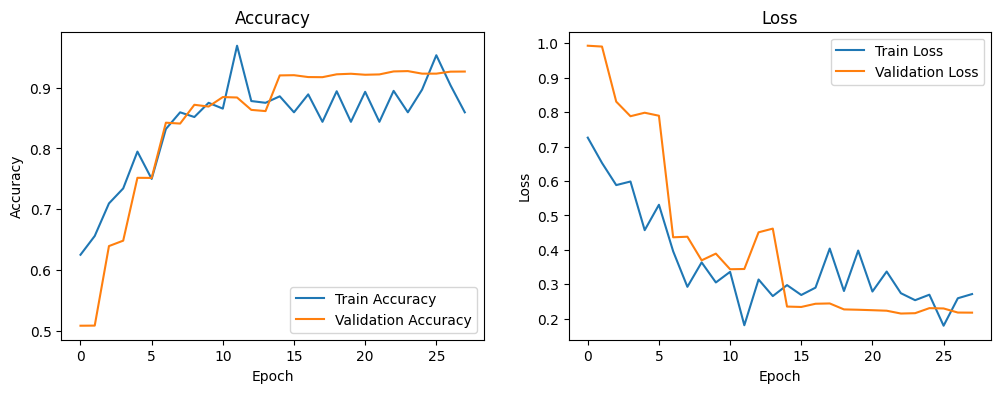

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show();

In [21]:
y_pred_probs = model.predict(X_test).ravel()

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


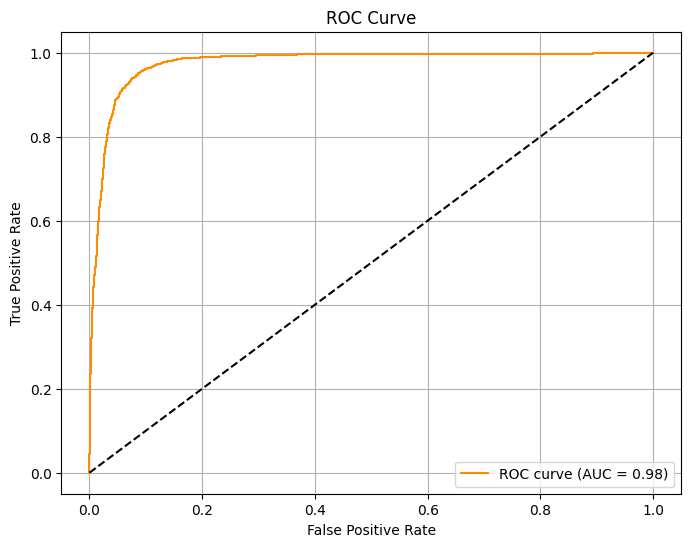

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

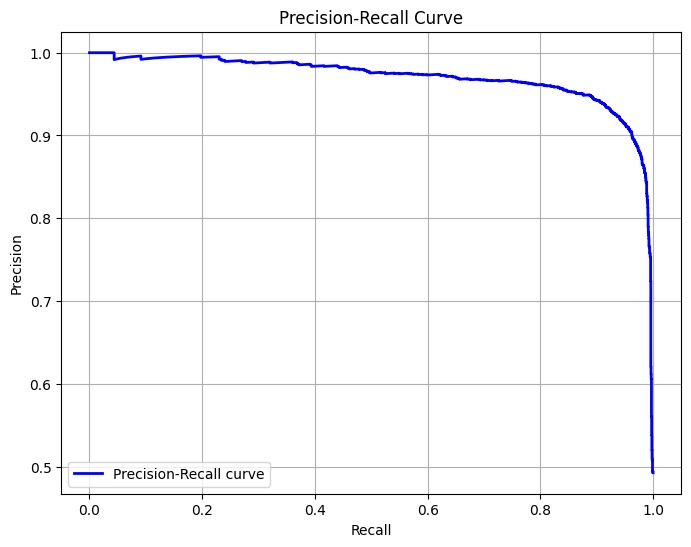

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve', color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show();

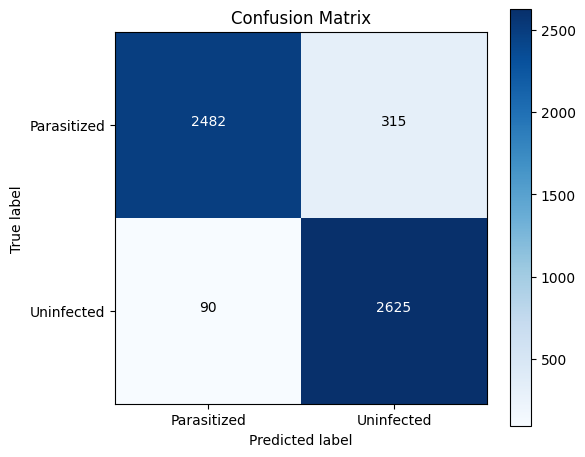

In [27]:
y_pred = (y_pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Parasitized', 'Uninfected'])
plt.yticks(tick_marks, ['Parasitized', 'Uninfected'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show();

In [28]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.92      2797
           1       0.89      0.97      0.93      2715

    accuracy                           0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512



## **Model Saving**
- The trained model is saved for future use, allowing it to be reloaded without retraining.

In [24]:
model.save('malaria_detection_model.keras')